In [112]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

# Contents
- [Introduction](#introduction)
- [Overview](#overview-of-the-model)
- [DSDP to solve the model](#solving-the-model-with-dsdp)
    - [Inputs](#1-inputs)
    - [Bellman equation and operators](#2-define-bellman-equation-and-operators)
    - [Value Function Iteration](#3-value-function-iteration)
    - [Solve the model](#4-get-value-and-policy-function)
    - [Simulation](#5-simulation)
- [Appendix: Broadcasting and expectation](#appendix-broadcasting)

# **Introduction**


- Previous Lecture
In the previous lecture, we studied **Markov chains** and their related concepts.

- Current Lecture
In this lecture, we build upon Markov chains and apply **discrete stochastic dynamic programming** to solve the consumer's optimal savings problem.

- Key Concepts and Methods
    1. **Tauchen Method**:  
        We use the Tauchen method to discretize exogenous income, which follows an **AR(1) process**.

    2. **Value Function Iteration**:  
        The consumer's optimal savings problem is solved through value function iteration over the space of wealth and income.

    3. **Stochastic Simulation**:  
        After solving the problem, we perform stochastic simulations to generate time series data.  
        We can then calculate the **correlation** and **autocorrelation** of these simulated time series and compare them to real-world data for validation or estimation (Simulated Moment Method).


# **Overview of the model**

We consider an optimal savings problem with CRRA utility and budget constraint

$$
Max \quad \sum_{t=0}^{\infty} \frac{C_t^{1+\gamma}}{1+\gamma} \\
W_{t+1} + C_t \leq R W_t + Y_t \\
W_0 \quad given \\
$$

where

- $ C_t $ is consumption and $ C_t \geq 0 $,  
- $ W_t $ is wealth and $ W_t \geq 0 $,  
- $ R > 0 $ is a gross rate of return, and  
- $ (Y_t) $ is labor income.  


We assume below that labor income is a discretized AR(1) process.

The Bellman equation is

$$
v(w) = \max_{0 \leq w' \leq Rw + y}
    \left\{
        u(Rw + y - w') + β \sum_{y'} v(w', y') Q(y, y') 
    \right\}
$$

where

$$
u(c) = \frac{c^{1-\gamma}}{1-\gamma}
$$

In the code we use the function

$$
B((w, y), w', v) = u(Rw + y - w') + β \sum_{y'} v(w', y') Q(y, y').
$$

the encapsulate the right hand side of the Bellman equation.

# **Solving the model with DSDP**

### 1. Inputs

The following function contains default parameters and returns tuples that
contain the key computational components of the model.

In [113]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2,                       # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5,                 # Max wealth
                             w_size=150,                # Grid side
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns parameters and grids 
    for the optimal savings problem.
    """
    
    # Build grids of wealth
    w_grid = np.linspace(w_min, w_max, w_size)
    
    # Build 
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = np.exp(mc.state_values), mc.P

    # Pack and return
    params = β, R, γ
    sizes = w_size, y_size
    arrays = w_grid, y_grid, Q

    return params, sizes, arrays

## 2. Define Bellman equation and operators

**We use a vectorized approach.**

The first step is to create **the right hand side of the Bellman equation as a multi-dimensional array with dimensions over all states and controls**.

In [114]:
def B(model,v):
    """
    A vectorized version of the right-hand side of the Bellman equation
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # unpack the model
    params, sizes, arrays = model
    β, R, γ = params
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute current consumption c(w, y, wp) as array c[i, j, ip]
        # i: dimension of w
        # j: dimension of y
        # ip: dimension of w'
    w = np.reshape(w_grid, (w_size, 1, 1))      # w[i]   ->  w[i, j, ip]
    y = np.reshape(y_grid, (1, y_size, 1))      # y[j]   ->  y[i, j, ip]
    wp = np.reshape(w_grid, (1, 1, w_size))     # w'[ip] ->  w'[i, j, ip]
    c = R*w + y - wp                            # c[i, j, ip] = R*w[i] + y[j] - wp[ip]

    # Calculate expected value at all combinations of (w, y, wp)
    v = np.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = np.reshape(Q, (1,y_size,1,y_size))     # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = np.sum(v * Q, axis=3)                 # EV[i,j,ip] = sum_jp (v[ip, jp] *  Q[j, jp])

    # if c<0, let the value function to be -inf
    # if c>0, return the RHS of Bellman equation (without 'max')
    return np.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -np.inf)


Here are two functions we need for value function iteration.

1. **Bellman operator** `T`
2. computes a **$ v $-greedy policy given $ v $**  `get_greedy`  
    (i.e., the policy that maximizes the right-hand side of the Bellman equation.)

In [115]:

def T(model,v):
    "The Bellman operator."
    # choose w' to maximize the RHS of Bellman equation
    return np.max(B(model,v), axis=2)

def get_greedy(model,v):
    "Computes a v-greedy policy, returned as a set of indices."
    # the index of optimal w'
    return np.argmax(B(model,v), axis=2)

## 3. Value function iteration

In [116]:
def value_function_iteration(model, max_iter=10_000, tol=1e-5):
    _, sizes,_ = model
    v = np.zeros(sizes)

    i, error = 0, tol+1
    while error > tol and i < max_iter:
        v_new = T(model,v)
        error = np.max(np.abs(v_new - v))
        i += 1
        v = v_new

        if error < tol:
            print('iteration succeed')

    return v, get_greedy(model,v)

## 4. Get Value and Policy Function

In [117]:
model = create_consumption_model()

# Unpack
params, sizes, arrays = model
β, R, γ = params
w_size, y_size = sizes
w_grid, y_grid, Q = arrays

# Value function iteration
v,policy = value_function_iteration(model, max_iter=10_000, tol=1e-5)

iteration succeed


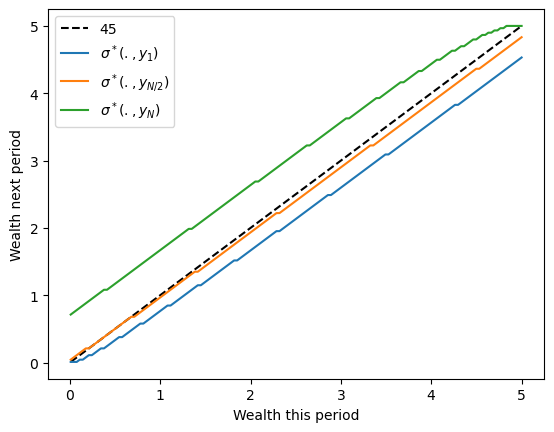

In [118]:
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[policy[:, 1]], label="$\\sigma^*(., y_1)$")
ax.plot(w_grid, w_grid[policy[:, 50]], label="$\\sigma^*(., y_{N/2})$")
ax.plot(w_grid, w_grid[policy[:, -1]], label="$\\sigma^*(., y_N)$")
ax.set_xlabel('Wealth this period')
ax.set_ylabel('Wealth next period')
ax.legend()
plt.show()

## 5. Simulation
When simulating using a policy function, we need to model the dynamic evolution of wealth and income. The steps for implementing the simulation are as follows:

1. **Initialize Starting Point**:  
   Choose the initial levels of wealth and income state.

2. **Choose Savings Based on Policy**:  
   At each time step, based on the current wealth and income state, use the policy to determine the next period’s savings level.

3. **Update Wealth and Income**:  
   Update the next period’s wealth and income state based on the savings decision and the income dynamics (using the Markov chain transition matrix $Q$).

4. **Repeat the Process**:  
   Iterate through these steps to generate a complete simulated path of wealth and income over time.

In [119]:
def simulate(model, policy, T=100, w0=1.0, y0_idx=50):
    """
    Simulate the wealth dynamics over T periods given the initial wealth and income state.
    
    Parameters:
    -----------
    model : tuple
        The model containing parameters, sizes, and grids.
    policy : ndarray
        The optimal policy (savings decisions).
    T : int
        Number of periods to simulate.
    w0 : float
        Initial wealth.
    y0_idx : int
        Initial income state index.
    
    Returns:
    --------
    wealth_path : ndarray
        The simulated wealth path.
    income_path : ndarray
        The simulated income path.
    """

    # Unpack the model
    params, sizes, arrays = model
    _, R, _ = params
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays
    
    # Initialize paths for wealth and income
    wealth_path = np.zeros(T)
    income_idx_path = np.zeros(T, dtype=int)

    
    # Set initial conditions
    wealth_path[0] = w0
    income_idx_path[0] = y0_idx
    
    # Start the simulation
    for t in range(T-1):
        # Find the index of the current wealth in the wealth grid
        w_idx = np.argmin(np.abs(w_grid - wealth_path[t]))

        # Get the income index for the current time period
        y_idx = income_idx_path[t]

        # Get the optimal savings based on the current wealth and income index
        w_next_idx = policy[w_idx, y_idx]
        w_next = w_grid[w_next_idx]

        # Update wealth for next period
        wealth_path[t+1] = R * wealth_path[t] + y_grid[y_idx] - w_next

        # Update income state for next period based on transition probabilities
        income_idx_path[t+1] = np.random.choice(np.arange(y_size), p=Q[y_idx])

    return wealth_path, income_idx_path

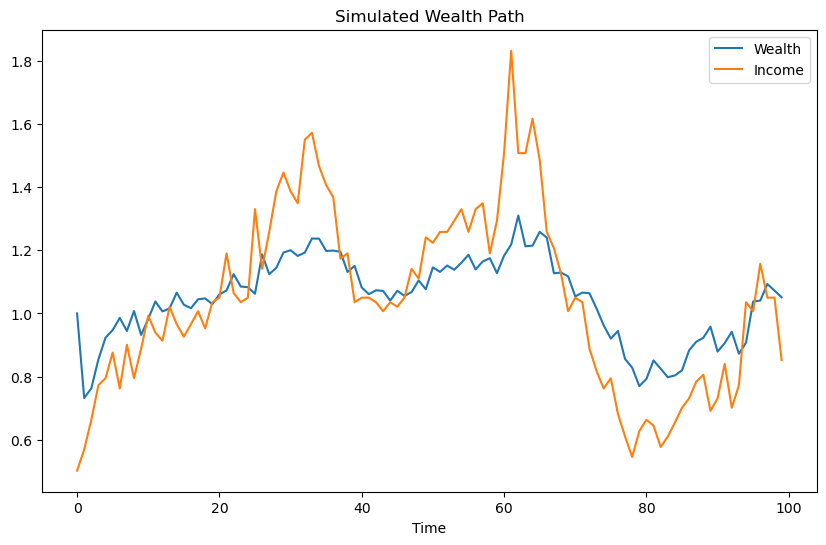

In [120]:
# Simulate with initial conditions
T = 100  # Number of periods to simulate
initial_wealth = 1.0  # Initial wealth
initial_income_idx = 0  # Index for initial income

wealth_path, income_idx_path = simulate(model, policy, T=T, w0=initial_wealth, y0_idx=initial_income_idx)
income_path = y_grid[income_idx_path]

# Plot the simulation results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(T), wealth_path, label="Wealth")
plt.plot(np.arange(T), income_path, label="Income")
plt.xlabel("Time")
plt.title("Simulated Wealth Path")
plt.legend()
plt.show()

# **Appendix: Broadcasting**

The **broadcast** mechanism in NumPy is primarily used for array operations. It allows smaller arrays to be automatically expanded to larger shapes without manually copying data, making array programming more efficient.  
Broadcasting enables operations between arrays of different shapes in a memory-efficient way.

**Broadcasting Rules:**
   1. **Same Dimensions**:  
      If two arrays have the same size in a particular dimension, they are compatible for broadcasting, and element-wise operations can be performed.
   
   2. **Automatic Dimension Expansion**:  
      If one array has a dimension of size 1, it can be expanded (broadcasted) to match the size of the other array along that dimension.

   3. **Error When Incompatible**:  
      If two arrays have incompatible sizes in a dimension (neither the same size nor 1), a `ValueError` is raised.

**Advantages:**  
   Compared to using loops over individual elements, broadcasting offers the following benefits:
   1. **Memory Efficiency**
   2. **Simplified Code**
   3. **Flexibility**

## **A.1. Basic Example: Using Broadcasting for Array Programming**

Assume we have two arrays, $a$ and $b$, with the following shapes:
$$
a = (a_1, a_2) \\
b = (b_1, b_2, b_3)
$$
We want to construct a matrix $Z$, where the element at the i-th row and j-th column is defined as:
$$
Z_{i,j} = ln(a_i) * ln(b_j)
$$
There are two approaches to achieve this:

**Approach A: Loop**  
   Using loops over the arrays, we can manually calculate each element of $Z$.

**Approach B: Broadcasting**  
   1. First, calculate the logarithms of the arrays $a$ and $b$, denoted as `ln_a` and `ln_b`, where each element is the logarithmic transformation of $a$ and $b`.
   2. Reshape `ln_a` and `ln_b` as needed.
   3. When multiplying the arrays, Python will automatically apply broadcasting:
   
   $$
   Z =
   \begin{pmatrix}
   ln(a_1) \\ ln(a_2)
   \end{pmatrix}
   *
   \begin{pmatrix}
   ln(b_1) & ln(b_2) & ln(b_3)
   \end{pmatrix}
   =
   \begin{pmatrix}
   ln(a_1) & ln(a_1) & ln(a_1) \\
   ln(a_2) & ln(a_2) & ln(a_2)\\
   \end{pmatrix}
   *
   \begin{pmatrix}
   ln(b_1) & ln(b_2) & ln(b_3) \\ 
   ln(b_1) & ln(b_2) & ln(b_3)
   \end{pmatrix}
   $$
   where "$*$" denotes element-wise array multiplication.

This method can replace loops over arrays and make the calculations more efficient using broadcasting.

In [121]:
a = np.array([3,4])
b = np.array([6,7,8])
size_a = a.shape[0]
size_b = b.shape[0]

# plan A:
Z1 = np.zeros((size_a,size_b))
for i in range(size_a):
    for j in range(size_b):
        Z1[i,j] = np.log(a[i]) * np.log(b[j])
print('Result of Plan A:')
print(Z1)


# Plan B (faster,simpler)
ln_a = np.log(a)
ln_b = np.transpose(np.log(b))

ln_at = np.reshape(ln_a,(size_a,1)) # (i) -> (i,1)
ln_bt = np.reshape(ln_b,(1,size_b)) # (j) -> (1,j)
Z2=ln_at * ln_bt                    # (i,1) * (1,j) -> (i,j)
print('Result of Plan B:')
print(Z2)


Result of Plan A:
[[1.96844897 2.1378008  2.28450003]
 [2.48390605 2.69760427 2.88271808]]
Result of Plan B:
[[1.96844897 2.1378008  2.28450003]
 [2.48390605 2.69760427 2.88271808]]


## **A.2. Error Example**

If the broadcasting mechanism cannot make two arrays compatible, a **ValueError** will be raised. 

In the following example:  
The shape of array $a$ is `(2, 3)`, and the shape of array $b$ is `(2, 2)`.  
Since the arrays have different dimensions, and the smaller dimension is not equal to 1, broadcasting cannot be applied, and Python will raise a `ValueError`.


In [122]:
a = np.array([[1, 2, 3],
              [4, 5, 6]])
b = np.array([[1, 2],
              [2, 2]])

result = a + b

ValueError: operands could not be broadcast together with shapes (2,3) (2,2) 

## **A.3. Using NumPy Broadcasting to Calculate Expected Values**

### 1. Expected Value of a Single Random Variable

Assume we have a random variable $X$ that can take on three possible values: [1, 2, 3], with corresponding probabilities [0.2, 0.5, 0.3]. The expected value of $X$ is calculated as follows:

$$
E(X) = 1 * 0.2 + 2 * 0.5 + 3 * 0.3 = 2.1
$$

In [123]:
x = np.array([1, 2, 3])  # possible value of X
p = np.array([0.2, 0.5, 0.3])  # corresponding probability

# Calculating the expectation
expectation = np.sum(x * p)
print(expectation)

2.0999999999999996


### 2. Expected Value of Multiple Random Variables

Now, let’s extend the concept to two sets of random variables:
- The first set has values [1, 2, 3], with corresponding marginal probabilities [0.2, 0.5, 0.3].
- The second set has values [4, 5, 6], with corresponding marginal probabilities [0.1, 0.6, 0.3].

We calculate the expected value of these two sets of random variables simultaneously

In [124]:
x = np.array([[1, 2, 3], [4, 5, 6]])  # possible values of two variable
p = np.array([[0.2, 0.5, 0.3], [0.1, 0.6, 0.3]])  # corresponding probability

# expectation
expectation = np.sum(x * p, axis=1)
print(expectation)

[2.1 5.2]


### 3. Conditional Expectation in a Markov Chain

#### 3.1 Problem Description

Suppose we have a Markov chain $ s_t \in \mathbb{S} $ with the state space:
$$
\mathbb{S} = \{1, 2, 3\}
$$
The state transition probability matrix $ P $ is defined as:
$$
P =
\begin{pmatrix}
0.1 & 0.2 & 0.7 \\
0.6 & 0.1 & 0.3 \\
0.2 & 0.4 & 0.4 \\
\end{pmatrix}
$$
Here, the $i$-th row of matrix $P$ represents the probability distribution of transitioning from state $i$ to other states.

We want to calculate the conditional expectation of the future state $\mathbb{E}[s_{t+k} \mid s_t = 1]$, which represents the expected state after $k$ steps given that the current state is $s_t = 1$.

#### 3.2 Solution

1. **State Transitions in a Markov Chain**:  
   Given the transition matrix $P$, we can compute the probability distribution of transitioning from state $s_t$ to state $s_{t+k}$ using matrix multiplication.

   To calculate the transition probabilities after $k$ steps, we raise matrix $P$ to the power of $k$, which gives $P^k$. The $i$-th row of $P^k$ represents the probability distribution of transitioning from state $i$ after $k$ steps.

   Therefore, the conditional expectation can be expressed as:
   $$
   \mathbb{E}[s_{t+k} \mid s_t = x] = \sum_{s' \in \mathbb{S}} s' \cdot P^k(x, s')
   $$
   where $P^k(x, s')$ is the probability of transitioning to state $s'$ from the initial state $x$ after $k$ steps.

2. **Step-by-Step Breakdown**:
   
   - **Calculate $P^k$**: Compute the $k$-step transition probability matrix by multiplying $P$ by itself $k$ times.
   - **Compute Conditional Expectation**: For the initial state $s_t = x$, use the corresponding row of $P^k$ and the states in the state space $ \mathbb{S} $ to perform a weighted sum to calculate the conditional expectation.


In [125]:
# state transition probability
P = np.array([[0.1, 0.2, 0.7],
              [0.6, 0.1, 0.3],
              [0.2, 0.4, 0.4]])

# state space
states = np.array([1, 2, 3])

# steps
k = 2

# P^k
P_k = np.linalg.matrix_power(P, k)

# index for initial state s_t = 1
initial_state_index = 0

# conditional expected value 
expected_value = np.sum(P_k[initial_state_index] * states)

print(f"E[s_t+2 | st=1] = {expected_value}")

E[s_t+2 | st=1] = 2.14
